# Boruta SHAP: 모든 data scientist가 알아야 할 feature selection을 위한 도구

출처: [https://towardsdatascience.com/boruta-shap-an-amazing-tool-for-feature-selection-every-data-scientist-should-know-33a5f01285c0](https://towardsdatascience.com/boruta-shap-an-amazing-tool-for-feature-selection-every-data-scientist-should-know-33a5f01285c0)

# Python 예제로 놀라운 feature selection 프로세스를 구축하기 위해 Boruta와 SHAP을 사용하는 방법

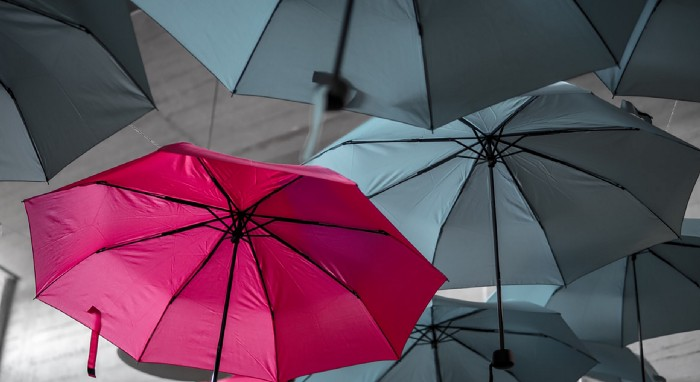

Machine learning 모델을 구축할 때 feature가 너무 많으면 더 많은 메모리, 처리 시간 및 전력이 필요한 것 외에도 차원의 저주와 같은 문제가 발생한다는 것을 알고 있습니다.

Feature engineering 파이프라인에서 feature selection 기술을 사용하여 데이터 세트에서 덜 유용한 features를 제거할 것입니다. 여기서 문제는 우리가 '어떤 features가 유용한지 어떻게 결정하느냐'라는 것입니다.

이 task를 위해 통계적 접근 방식을 기반으로 하는 feature selection 알고리즘인 Boruta를 사용할 수 있습니다. Boruta 알고리즘은 shadow features와 이항 분포라는 두 가지 원칙을 이용합니다.

# 1. Shadow Features
Boruta 알고리즘의 첫 번째 단계는 feature importances를 평가하는 것입니다. 일반적으로 Boruta는 트리 기반 알고리즘에서 수행되지만, Boruta에서는 feature가 서로 경쟁하지 않고 "shadow features"라는 randomized 버전과 경쟁을 합니다.

3개의 features와 100개의 observations가 있는 데이터 세트가 있다고 가정해 보겠습니다. 이 경우, 데이터 세트의 복사본을 만들고 각 feature 칼럼을 섞습니다. 그런 다음, 재배치된 features를 "shadow features"라고 하는데 이 3개의 새 shadow features와 3개의 기존 features를 모두 합쳐 새 데이터 세트인 Boruta 데이터 세트를 만듭니다.

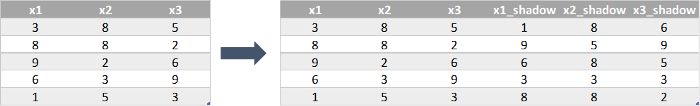

이제 RandomForest와 같은 선호하는 method를 사용하여 6가지 features 모두의 feature importances를 평가합니다. Boruta 알고리즘의 아이디어는 여기에서 shadow features로 표현되는 pure randomness보다 더 나은 성능을 보이는 feature를 선택하는 것이므로, 원래 features의 importances와 shadow features의 가장 높은 features importances를 비교합니다. 그리고 feature의 importance가 이 threshold보다 높을 때마다 "hit"이라고 합니다.

이제 hit인 칼럼만 유지하고 나머지는 제거할 수 있습니다. 하지만, features 중 일부가 단순히 운이 좋지 않아 제거된 것이라면 어떻게 될까요? 답은 반복에 있고, 다음 단계에서 이를 다룹니다.

# 2. Binomial Distributions
모든 features는 "hit" 또는 "no hit"라는 두 가지 결과만 가지므로, 이전 단계를 여러 번 수행하고 features에서 이항 분포를 구축할 수 있습니다.

"genre", "audience_score" 및 "critic_score"의 세 가지 features가 있는 영화 데이터 세트를 생각해볼 때, 20번의 반복에서 다음과 같은 결과를 얻을 수 있습니다:

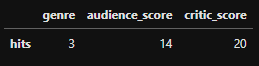

이러한 결과들을 이항 분포 plot에 다음과 같이 위치시킬 수 있습니다:

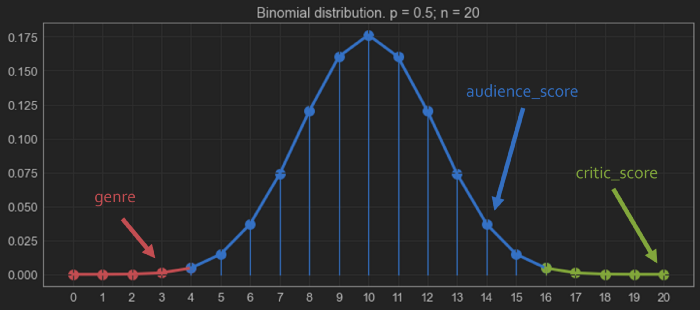

분포의 tail이 가장 중요한 부분입니다. 예에서 각각 확률의 0.5%를 나타냅니다.

변수는 "reject" 영역인 빨간색 영역에 위치해 있습니다. 여기서 feature가 target 변수에 영향을 미치지 않을 것이라고 확신할 수 있습니다.

녹색 영역은 "acceptance" 영역입니다. 여기서 또한 이러한 features가 예측 가능하기 때문에 모델에 유지되어야 한다고 확신할 수 있습니다. 이 예에서는 유지해야 하는 좋은 feature입니다.

파란색 영역에서 Boruta는 해당 feature가 예측이 가능한지 여부를 결정하지 못합니다. 따라서, 이 경우, feature를 유지할 수도 있고 다른 방법을 사용하여 모델 예측에 영향을 미치는지 확인할 수도 있습니다.

> 여기서는 녹색과 파란색 영역에 분류된 features는 유지하고, 빨간색 영역에 있는 features는 제거합니다.

Boruta algorithm에 대한 훌륭한 설명은 [여기](https://choisk7.github.io/ml/Boruta_Explained_Exactly_How_You_Wished_Someone_Explained_to_You/)에서 확인할 수 있습니다.

# 3. Boruta in Python


In [2]:
# pip install boruta

In [3]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

dataset = load_diabetes(as_frame=True)
X = dataset["data"]
y = dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.ensemble import RandomForestRegressor

# boruta에서 사용할 estimator
estimator = RandomForestRegressor()

이제 BorutaPy 오브젝트를 만들어 데이터를 학습시킵니다.

In [5]:
from boruta import BorutaPy

boruta = BorutaPy(estimator=estimator, n_estimators="auto", max_iter=100)
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(n_estimators=44,
                                         random_state=RandomState(MT19937) at 0x19B91B05540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x19B91B05540)

이제 features의 중요한 정도를 파악할 수 있습니다

In [6]:
important = list(X.columns[boruta.support_])
print(f"Features confirmed as important: {important}")

tentative = list(X.columns[boruta.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

unimportant = list(X.columns[~(boruta.support_ | boruta.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['bmi', 'bp', 's5']
Unconfirmed features (tentative): []
Features confirmed as unimportant: ['age', 'sex', 's1', 's2', 's3', 's4', 's6']


# 4. Boruta SHAP Feature Selection
Boruta는 feature selection을 위한 강력한 방법이지만, 데이터에 대해 편향되거나 충분하지 않은 데이터에서 나온 feature importances 계산에 크게 의존합니다.

SHAP Values를 Boruta의 feature selection 방법으로 사용합니다. 이 접근 방식을 사용하면 SHAP 방법에 존재하는 강력한 addictive feaeture explanations를 얻을 수 있으며, 중요한 변수만 데이터 세트에 남도록 boruta 알고리즘의 robustness를 유지할 수 있습니다.

SHAP가 무엇인지 모르는 경우 설명하는 다음 링크의 글을 보세요: [SHAP values 설명](https://choisk7.github.io/ml/Using_SHAP_Values_to_Explain_How_Your_Machine_Learning_Model_Works/)

# 5. Boruta SHAP in Python

In [9]:
# !pip install BorutaShap

먼저 BorutaShap object를 생성해야 합니다. SHAP를 feature importance 판별기로 사용하기를 원하기 때문에 기본값은 "shap"입니다. 문제가 분류 문제일 때 parameter를 True로 변경할 수 있습니다.

In [10]:
from BorutaShap import BorutaShap

selector = BorutaShap(importance_measure="shap", classification=False)

그런 다음, 데이터 또는 데이터 샘플에 BorutaShap selector에 학습시킵니다. parameter는 boruta 알고리즘의 반복 횟수를 정의하는 반면 boolean은 프로세스 속도를 높이기 위해 method가 내부적으로 데이터를 샘플링할지 여부를 결정합니다.

In [11]:
selector.fit(X=X_train, y=y_train, n_trials=100, sample=False, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

3 attributes confirmed important: ['s5', 'bp', 'bmi']
6 attributes confirmed unimportant: ['s4', 's2', 's1', 'sex', 's3', 'age']
1 tentative attributes remains: ['s6']


최종적으로, 어떤 features가 삭제되는지 볼 수 있습니다.

In [12]:
features_to_remove = selector.features_to_remove
print(features_to_remove)

X_train_boruta_shap = X_train.drop(columns=features_to_remove)
X_test_boruta_shap = X_test.drop(columns=features_to_remove)

['age' 'sex' 's1' 's2' 's3' 's4']


# 6. Conclusion
이 방법의 단점은 많은 Boruta 반복이나 SHAP가 많은 observations에 대해 학습할 때, evaluation 시간이 너무 길 수 있다는 것입니다.

하지만, Boruta SHAP는 machine learning pipelines에서 가장 중요한 features를 선택하는 데 사용할 수 있는 최고의 방법 중 하나입니다.

> 항상 사용하되, 결과를 다른 methods와 비교하는 것을 잊지 마세요